# Northwind database analysis

## Executive Summary 

In [1]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# create the SQL engine
# to use the large version of the databse:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# to use the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)

Session = sessionmaker(bind=engine)
session = Session()


In [3]:
# have a look at the tables
inspector = inspect(engine)
print(inspector.get_table_names())


2019-04-12 21:12:57,459 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-12 21:12:57,461 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:12:57,463 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-12 21:12:57,464 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:12:57,466 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-12 21:12:57,468 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

get_columns_info('OrderDetail')




2019-04-12 21:12:57,482 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-04-12 21:12:57,484 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


In [5]:
con = engine.connect()
rs = con.execute('SELECT * FROM Customer LIMIT 5')

print(rs.fetchall())



2019-04-12 21:12:57,494 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer LIMIT 5
2019-04-12 21:12:57,495 INFO sqlalchemy.engine.base.Engine ()
[('ALFKI', 'Alfreds Futterkiste', 'Maria Anders', 'Sales Representative', 'Obere Str. 57', 'Berlin', 'Western Europe', '12209', 'Germany', '030-0074321', '030-0076545'), ('ANATR', 'Ana Trujillo Emparedados y helados', 'Ana Trujillo', 'Owner', 'Avda. de la Constitución 2222', 'México D.F.', 'Central America', '05021', 'Mexico', '(5) 555-4729', '(5) 555-3745'), ('ANTON', 'Antonio Moreno Taquería', 'Antonio Moreno', 'Owner', 'Mataderos  2312', 'México D.F.', 'Central America', '05023', 'Mexico', '(5) 555-3932', None), ('AROUT', 'Around the Horn', 'Thomas Hardy', 'Sales Representative', '120 Hanover Sq.', 'London', 'British Isles', 'WA1 1DP', 'UK', '(171) 555-7788', '(171) 555-6750'), ('BERGS', 'Berglunds snabbköp', 'Christina Berglund', 'Order Administrator', 'Berguvsvägen  8', 'Luleå', 'Northern Europe', 'S-958 22', 'Sweden', '0921-12 34 

In [6]:
rs = con.execute('SELECT firstname, lastname, title FROM Employee')
df = pd.DataFrame(rs.fetchall())

df.head()



2019-04-12 21:12:57,504 INFO sqlalchemy.engine.base.Engine SELECT firstname, lastname, title FROM Employee
2019-04-12 21:12:57,506 INFO sqlalchemy.engine.base.Engine ()


,0,1,2
0,Nancy,Davolio,Sales Representative
1,Andrew,Fuller,"Vice President, Sales"
2,Janet,Leverling,Sales Representative
3,Margaret,Peacock,Sales Representative
4,Steven,Buchanan,Sales Manager


In [7]:
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols


In [8]:
# small sample of order detail for testing
# rs = con.execute('SELECT * FROM OrderDetail LIMIT 25')

# get full orderdetail
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-04-12 21:12:57,548 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-04-12 21:12:57,550 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
column_names = make_column_list('Order')
column_names

2019-04-12 21:12:57,574 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-04-12 21:12:57,576 INFO sqlalchemy.engine.base.Engine ()


['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [10]:
# test of customer table to pandas dataframe
rs = con.execute('SELECT * FROM Customer LIMIT 5')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head()


2019-04-12 21:12:57,591 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer LIMIT 5
2019-04-12 21:12:57,594 INFO sqlalchemy.engine.base.Engine ()
2019-04-12 21:12:57,597 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-04-12 21:12:57,598 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [11]:
# test orders table
# rs = con.execute('SELECT * FROM [Order]')
# orders = pd.DataFrame(rs.fetchall())
# orders.head()


# get full orders
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names

orders.head()

2019-04-12 21:12:57,621 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-04-12 21:12:57,624 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [12]:
# get full customer
rs = con.execute('SELECT * FROM Customer')
customer = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Customer')
customer.columns = column_names

customer.head()

2019-04-12 21:12:57,659 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-04-12 21:12:57,660 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


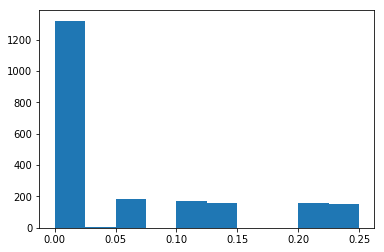

In [13]:
plt.hist(order_detail["Discount"])
plt.show()

In [14]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])




In [15]:
order_detail.head()




,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [16]:
order_detail.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,587.374960
std,241.378032,22.159019,29.827418,19.022047,0.083450,969.224235
min,10248.000000,1.000000,2.000000,1.000000,0.000000,4.800000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,147.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,337.750000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,656.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,15810.000000


Idea: Compare orders that contain at least one discounted item to orders that have no discounts.
* Is the average order total higher?
* Is the count of total items ordered higher?
* Is the count of unique products higher?

From prior labs:
q = """SELECT LastName, FirstName, COUNT(*) as TerritoriesAssigned from \
Employee \
JOIN EmployeeTerritory et on Employee.Id = et.employeeId \
GROUP BY Employee.lastname \
ORDER BY TerritoriesAssigned DESC"""

In [17]:
# rs = con.execute('SELECT * FROM [Order] JOIN OrderDetail on Order.OrderID = OrderDetail.OrderID WHERE OrderDetail.Discount > 0')
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()
orders_with_discount.head()


2019-04-12 21:12:58,591 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-04-12 21:12:58,594 INFO sqlalchemy.engine.base.Engine ()


,Id
0,10250
1,10251
2,10252
3,10254
4,10258


380 out of 830 orders have at least one discounted product on the order.

In [18]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [19]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

# orders_without_discount.head()

orders_without_discount.count()

# sources
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe
# https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

In [20]:
rs = con.execute('SELECT * FROM OrderDetail JOIN [Order] on OrderDetail.Id = [Order].Id')
temp_df = pd.DataFrame(rs.fetchall())
temp_df.head(10)

2019-04-12 21:12:58,673 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail JOIN [Order] on OrderDetail.Id = [Order].Id
2019-04-12 21:12:58,676 INFO sqlalchemy.engine.base.Engine ()


""


In [21]:
orders['Id'].dtype

dtype('int64')

add these columns to the order dataframe: 
* order_total
* unique_products_count
* all_items_total_qty_count

In [22]:
order_detail.head()
print(order_detail.loc[order_detail['OrderId'] == 10248])
# print(df.loc[df['A'] == 'foo'])

         Id  OrderId  ProductId  UnitPrice  Quantity  Discount  line_total
0  10248/11    10248         11       14.0        12       0.0       168.0
1  10248/42    10248         42        9.8        10       0.0        98.0
2  10248/72    10248         72       34.8         5       0.0       174.0


In [24]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0


In [26]:
# get new column values, add to orders dataframe
for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index =  orders.loc[orders['Id'] == order_id].index   #  order_index:  Int64Index([0], dtype='int64')
    
#     print ("order_id: ", order_id)
#     print ("order_index: ", order_index[0])  
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
#     print(temp_df)
    
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    for index, row in temp_df.iterrows():
#         print(row)
        #for testing
#         print("UnitPrice: {}, Quantity: {}, Discount: {} ".format(row['UnitPrice'], row['Quantity'], row['Discount']))
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        #for testing
#     print("order_total: {}".format(order_total))
    
    #get the unique product id's
        product_ids.append(row['ProductId'])
        
    #count up the total # of units of all products in the order
        all_items_total_qty_count += row['Quantity']
    
    #make a set (only unique values)
    product_ids = set(product_ids)
    
# add these values to the order in the orders dataframe

#     print("Order {} complete. Order amount: {} - unique items: {} - item count: {}"
#           .format(order_id, order_total, len(product_ids), all_items_total_qty_count))
    
#     orders.iloc[order_index[0],'order_total'] = order_total
#     orders.ix[order_index[0], 'order_total'] = order_total  # .ix has been deprecated
    orders.iloc[order_index[0], orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index[0], orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index[0], orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    
#     print(orders.iloc[order_index[0]])
#     print(orders.loc[orders['Id'] == order_id])
#               df.loc[df['column_name'] == some_value]
    

Id                                               10248
CustomerId                                       VINET
EmployeeId                                           5
OrderDate                                   2012-07-04
RequiredDate                                2012-08-01
ShippedDate                                 2012-07-16
ShipVia                                              3
Freight                                          32.38
ShipName                     Vins et alcools Chevalier
ShipAddress                         59 rue de l'Abbaye
ShipCity                                         Reims
ShipRegion                              Western Europe
ShipPostalCode                                   51100
ShipCountry                                     France
order_total                                        440
unique_products_count                                3
all_items_total_qty_count                           27
Name: 0, dtype: object
Id                                        

Name: 44, dtype: object
Id                                         10293
CustomerId                                 TORTU
EmployeeId                                     1
OrderDate                             2012-08-29
RequiredDate                          2012-09-26
ShippedDate                           2012-09-11
ShipVia                                        3
Freight                                    21.18
ShipName                     Tortuga Restaurante
ShipAddress                     Avda. Azteca 123
ShipCity                             México D.F.
ShipRegion                       Central America
ShipPostalCode                             05033
ShipCountry                               Mexico
order_total                                848.7
unique_products_count                          4
all_items_total_qty_count                     33
Name: 45, dtype: object
Id                                                10294
CustomerId                                        RATTC
Employe

Id                                    10351
CustomerId                            ERNSH
EmployeeId                                1
OrderDate                        2012-11-11
RequiredDate                     2012-12-09
ShippedDate                      2012-11-20
ShipVia                                   1
Freight                              162.33
ShipName                       Ernst Handel
ShipAddress                    Kirchgasse 6
ShipCity                               Graz
ShipRegion                   Western Europe
ShipPostalCode                         8010
ShipCountry                         Austria
order_total                         5398.73
unique_products_count                     4
all_items_total_qty_count               120
Name: 103, dtype: object
Id                                                    10352
CustomerId                                            FURIB
EmployeeId                                                3
OrderDate                                      

Name: 169, dtype: object
Id                                      10418
CustomerId                              QUICK
EmployeeId                                  4
OrderDate                          2013-01-17
RequiredDate                       2013-02-14
ShippedDate                        2013-01-24
ShipVia                                     1
Freight                                 17.55
ShipName                           QUICK-Stop
ShipAddress                  Taucherstraße 10
ShipCity                            Cunewalde
ShipRegion                     Western Europe
ShipPostalCode                          01307
ShipCountry                           Germany
order_total                            1814.8
unique_products_count                       4
all_items_total_qty_count                 146
Name: 170, dtype: object
Id                                        10419
CustomerId                                RICSU
EmployeeId                                    4
OrderDate               

Id                                          10469
CustomerId                                  WHITC
EmployeeId                                      1
OrderDate                              2013-03-10
RequiredDate                           2013-04-07
ShippedDate                            2013-03-14
ShipVia                                         1
Freight                                     60.18
ShipName                     White Clover Markets
ShipAddress                   1029 - 12th Ave. S.
ShipCity                                  Seattle
ShipRegion                          North America
ShipPostalCode                              98124
ShipCountry                                   USA
order_total                                956.67
unique_products_count                           3
all_items_total_qty_count                      77
Name: 221, dtype: object
Id                                          10470
CustomerId                                  BONAP
EmployeeId               

Id                                          10525
CustomerId                                  BONAP
EmployeeId                                      1
OrderDate                              2013-05-02
RequiredDate                           2013-05-30
ShippedDate                            2013-05-23
ShipVia                                         2
Freight                                     11.06
ShipName                                 Bon app'
ShipAddress                  12, rue des Bouchers
ShipCity                                Marseille
ShipRegion                         Western Europe
ShipPostalCode                              13008
ShipCountry                                France
order_total                                 818.4
unique_products_count                           2
all_items_total_qty_count                      45
Name: 277, dtype: object
Id                                    10526
CustomerId                            WARTH
EmployeeId                           

Id                                    10583
CustomerId                            WARTH
EmployeeId                                2
OrderDate                        2013-06-30
RequiredDate                     2013-07-28
ShippedDate                      2013-07-04
ShipVia                                   2
Freight                                7.28
ShipName                     Wartian Herkku
ShipAddress                     Torikatu 38
ShipCity                               Oulu
ShipRegion                      Scandinavia
ShipPostalCode                        90110
ShipCountry                         Finland
order_total                          2237.5
unique_products_count                     3
all_items_total_qty_count                44
Name: 335, dtype: object
Id                                          10584
CustomerId                                  BLONP
EmployeeId                                      4
OrderDate                              2013-06-30
RequiredDate               

Id                                                    10660
CustomerId                                            HUNGC
EmployeeId                                                8
OrderDate                                        2013-09-08
RequiredDate                                     2013-10-06
ShippedDate                                      2013-10-15
ShipVia                                                   1
Freight                                              111.29
ShipName                         Hungry Coyote Import Store
ShipAddress                  City Center Plaza 516 Main St.
ShipCity                                              Elgin
ShipRegion                                    North America
ShipPostalCode                                        97827
ShipCountry                                             USA
order_total                                            1701
unique_products_count                                     1
all_items_total_qty_count               

Name: 536, dtype: object
Id                                               10785
CustomerId                                       GROSR
EmployeeId                                           1
OrderDate                                   2013-12-18
RequiredDate                                2014-01-15
ShippedDate                                 2013-12-24
ShipVia                                              3
Freight                                           1.51
ShipName                          GROSELLA-Restaurante
ShipAddress                  5ª Ave. Los Palos Grandes
ShipCity                                       Caracas
ShipRegion                               South America
ShipPostalCode                                    1081
ShipCountry                                  Venezuela
order_total                                      387.5
unique_products_count                                2
all_items_total_qty_count                           20
Name: 537, dtype: object
Id             

In [27]:
orders.head()



,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105


In [ ]:
plt.hist(order_detail['line_total'])






In [ ]:
plt.scatter(order_detail['Discount'], order_detail['line_total'])

Idea - Make a pandas dataframe of all orders where there is any item with a discount. 
Within those orders, what are the summary statistics for:
* The number of different SKU's in the order 
* Quantity of each SKU ordered. How does this compare to orders where the samei SKU has been ordered but there was no discount.
* 

And then compare those statistics to orders where there was no item with a discount.










In [ ]:
plt.scatter(order_detail['Discount'], order_detail['Quantity'])